In [26]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
chars = sorted(list(set(''.join(words))))

# util

In [6]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [7]:
stoi = {s: i for i, s in itos.items()}

In [8]:
vocab_size = len(stoi)
vocab_size

27

# Build a neural language model

## prepare data

In [9]:
block_size = 3
batch_size = 10

In [10]:
def build_dataset(data):
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [11]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Mimic PyTorch API

In [54]:
# ----------------------------------    
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
# ----------------------------------    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
# ----------------------------------    
class Embedding:
    def __init__(self, num_embd, embd_dim):
        self.weight = torch.randn(num_embd, embd_dim)

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

# ----------------------------------    
class Flatten():
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
# ----------------------------------    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# Train a neural language model

In [72]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [73]:
# C = torch.randn(len(itos), 10)
# w1 = torch.randn(30, 200)
# b1 = torch.randn(200)
# w2 = torch.randn(200, len(itos)) * 0.02
# b2 = torch.randn(len(itos)) * 0.01
# parameters = [C, w1, b1, w2, b2]

In [74]:
loglossi = []
lossi = []
STEPS = 800_000
# STEPS = 10_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < STEPS//2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

100%|██████████████████████████████████████████████████████████████| 800000/800000 [04:52<00:00, 2738.03it/s]


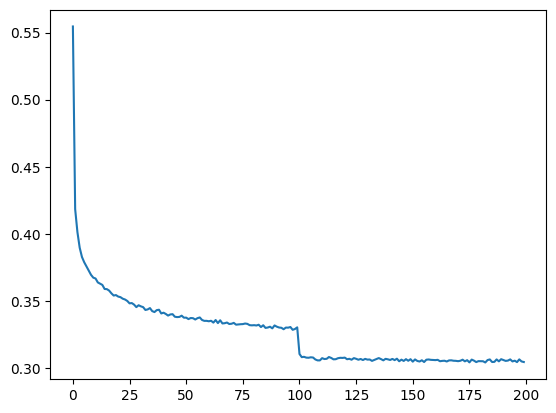

In [75]:
plt.plot(torch.tensor(loglossi).view(200, -1).mean(1))

## compute loss on train/dev/test

In [76]:
def eval_dataset(X, Y):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [77]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.0297372341156006
2.1115517616271973


## visualize the embedding

In [78]:
from sklearn.manifold import TSNE

In [93]:
tsne = TSNE(n_components=2, verbose=1, random_state=1234, perplexity=3)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)

In [94]:
z = tsne.fit_transform(C.detach().numpy())

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.001s...
[t-SNE] Computed neighbors for 27 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.934622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.637840
[t-SNE] KL divergence after 1000 iterations: 0.687416


In [95]:
C.shape, z.shape

(torch.Size([27, 10]), (27, 2))

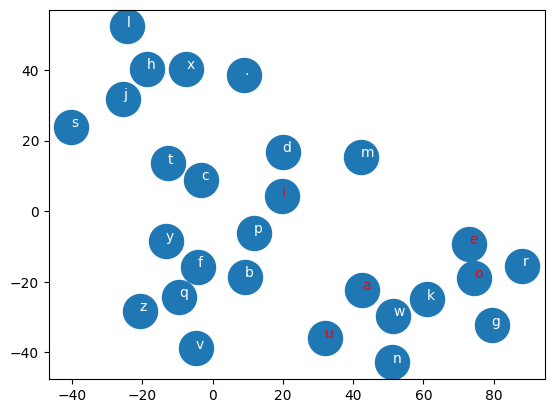

In [96]:
plt.scatter(z[:,0].data, z[:,1].data, s=600)
for i in range(z.shape[0]):
    if itos[i] in 'aeiou':
        c = 'red'
    else:
        c = 'white'
    plt.text(z[i,0].item(), z[i,1].item(), itos[i], color=c)

# generate names

In [97]:
g = torch.Generator().manual_seed(2147483647 + 10)

In [98]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khy.
mili.
taty.
skanden.
jazzube.
deliah.
jareei.
nellara.
